In [127]:
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
from cora_loader import CitationNetwork,CocitationNetwork,ConfigurationModelCitationNetwork
from multi_layered_model import MonoModel,BiModel,TriModel
from torch_geometric.nn import GCNConv,SAGEConv,GATConv
import time
import torch.nn.functional as F
import copy
import numpy as np
import random
import warnings
import pandas as pd
from bayes_opt import BayesianOptimization
warnings.filterwarnings('ignore')

In [4]:
cora = CitationNetwork('/tmp/cora2','cora',directed=True)
# citeseer = CitationNetwork('/tmp/citeseer','citeseer',directed=False)
# PubMed = CitationNetwork('/tmp/PubMed','PubMed',directed=False)

In [5]:
# coraReversed = CitationNetwork('/tmp/coraReversed','cora',directed=True,reverse=True)
# citeseerReversed = CitationNetwork('/tmp/citeseerReversed','citeseer',directed=True,reverse=True)
# PubMedReversed = CitationNetwork('/tmp/PubMedReversed','PubMed',directed=True,reverse=True)

In [6]:
# coraDirected = CitationNetwork('/tmp/coraDirected','cora',directed=True)
# citeseerDirected = CitationNetwork('/tmp/citeseerDirected','citeseer',directed=True)
# PubMedDirected = CitationNetwork('/tmp/PubMedDirected','PubMed',directed=True)

In [7]:
class MonoGAT(torch.nn.Module):
    def __init__(self,dataset,channels,heads=1,dropout=0.6,attention_dropout=0.3):
        super(MonoGAT,self).__init__()
        channels = [dataset.num_node_features] + channels + [dataset.num_classes]
        
        self.dropout = dropout
        self.attention_dropout = attention_dropout
        
        self.conv = []
        for i in range(1,len(channels)):
            if i == 1:
                conv = GATConv(channels[i-1],channels[i],heads=heads,dropout=self.attention_dropout)
            elif i == len(channels)-1:
                if dataset.name=='PubMed':
                    conv = GATConv(channels[i-1]*heads,channels[i],heads=heads,concat=False,dropout=self.attention_dropout)
                else:
                    conv = GATConv(channels[i-1]*heads,channels[i],dropout=self.attention_dropout)
            else:
                conv = GATConv(channels[i-1]*heads,channels[i],heads=heads,dropout=self.attention_dropout)
            self.add_module(str(i),conv)
            self.conv.append(conv)
        
        
    def forward(self, data): 
        x, edge_index = data.x, data.edge_index 
        
        for conv in self.conv[:-1]:
            x = conv(x,edge_index)
            x = F.elu(x)
            x = F.dropout(x,p=self.dropout,training=self.training) # YOU MUST UNDERSTAND DROPOUT (in attention)
        
        # Last layer
        x = self.conv[-1](x,edge_index)
        x = F.softmax(x,dim=1)
        
        return x
    

class BiGAT(torch.nn.Module):
    def __init__(self,dataset,channels,heads=1,dropout=0.6,attention_dropout=0.3):
        super(BiGAT,self).__init__()
        self.conv_st = []
        self.conv_ts = []
        self.dropout = dropout
        self.attention_dropout = attention_dropout
        channels_output = [dataset.num_node_features] + [c*2*heads for c in channels]
        channels = [dataset.num_node_features] + channels
        for i in range(len(channels)-1):
            conv_st = GATConv(channels_output[i], channels[i+1],heads=heads,dropout=self.attention_dropout)
            self.add_module('conv_st'+str(i),conv_st)
            self.conv_st.append(conv_st)
            
            conv_ts = GATConv(channels_output[i], channels[i+1],heads=heads,dropout=self.attention_dropout)
            self.add_module('conv_ts'+str(i),conv_ts)
            self.conv_ts.append(conv_ts)
        
        if dataset.name=='PubMed':
            self.last = GATConv(channels_output[-1], dataset.num_classes,heads=heads,concat=False,dropout=self.attention_dropout)
        else:
            self.last = GATConv(channels_output[-1], dataset.num_classes,dropout=self.attention_dropout)
        
    def forward(self, data): 
        x, edge_index = data.x, data.edge_index
        st_edges = data.edge_index.t()[1-data.is_reversed].t()
        ts_edges = data.edge_index.t()[data.is_reversed].t()
#         print(ts_edges.shape)
        for i in range(len(self.conv_st)):
            x1 = F.elu(self.conv_st[i](x,st_edges))
            x2 = F.elu(self.conv_ts[i](x,ts_edges))
            x = torch.cat((x1,x2),dim=1)
            x = F.dropout(x,p=self.dropout,training=self.training)
        
        # last layer
        x = self.last(x,edge_index)
        x = F.softmax(x,dim=1) 
        
        return x
    
class TriGAT(torch.nn.Module):
    def __init__(self,dataset,channels,heads=1,dropout=0.6,attention_dropout=0.3):
        super(TriGAT,self).__init__()
        self.conv_st = []
        self.conv_ts = []
        self.conv = []
        self.dropout = dropout
        self.attention_dropout = attention_dropout
        channels_output = [dataset.num_node_features] + [c*3*heads for c in channels]
        channels = [dataset.num_node_features] + channels
        for i in range(len(channels)-1):
            conv_st = GATConv(channels_output[i], channels[i+1],heads=heads,dropout=self.attention_dropout)
            self.add_module('conv_st'+str(i),conv_st)
            self.conv_st.append(conv_st)
            
            conv_ts = GATConv(channels_output[i], channels[i+1],heads=heads,dropout=self.attention_dropout)
            self.add_module('conv_ts'+str(i),conv_ts)
            self.conv_ts.append(conv_ts)
            
            conv = GATConv(channels_output[i],channels[i+1],heads=heads,dropout=self.attention_dropout)
            self.add_module('conv'+str(i),conv)
            self.conv.append(conv)
        
        if dataset.name=='PubMed':
            self.last = GATConv(channels_output[-1], dataset.num_classes,heads=heads,concat=False,dropout=self.attention_dropout)
        else:
            self.last = GATConv(channels_output[-1], dataset.num_classes,dropout=self.attention_dropout)
        
    def forward(self, data): 
        x, edge_index = data.x, data.edge_index
        st_edges = data.edge_index.t()[1-data.is_reversed].t()
        ts_edges = data.edge_index.t()[data.is_reversed].t()
#         print(ts_edges.shape)
        for i in range(len(self.conv_st)):
            x1 = F.elu(self.conv_st[i](x,st_edges))
            x2 = F.elu(self.conv_ts[i](x,ts_edges))
            x3 = F.elu(self.conv[i](x,edge_index))
            x = torch.cat((x1,x2,x3),dim=1)
            x = F.dropout(x,p=self.dropout,training=self.training)
        
        # last layer
        x = self.last(x,edge_index)
        x = F.softmax(x,dim=1) 
        
        return x

In [116]:
class NetworkSplitShcur:
    
    def __init__(self, data, train_examples_per_class=20,early_examples_per_class=20,
                 val_examples_per_class=30 , split_seed = 0):
        self.data = data
        
        random.seed(split_seed)
        target = [x.item() for x in self.data.y]
        num_samples = len(target)
        indices = range(num_samples)
        labels = set(target)
        num_classes = len(labels)
        
        train_idx = []
        for c in range(num_classes):
            train_idx += [x for x in random.sample([i for i in indices if target[i]==c],
                                                   train_examples_per_class)]
        self.train_mask = [1 if i in train_idx else 0 for i in range(num_samples)]

        rest = [x for x in indices if not self.train_mask[x]]
        early_idx = []
        for c in range(num_classes):
            early_idx += [x for x in random.sample([i for i in indices if i in rest and target[i]==c],
                                                   early_examples_per_class)]
        self.early_mask = [1 if i in early_idx else 0 for i in range(num_samples)]

        rest = [x for x in rest if not self.early_mask[x]]
        val_idx = []
        for c in range(num_classes):
            val_idx += [x for x in random.sample([i for i in indices if i in rest and target[i]==c],
                                                   val_examples_per_class)]
        self.val_mask = [1 if i in val_idx else 0 for i in range(num_samples)]

        rest = [x for x in rest if not self.val_mask[x]]
        self.test_mask = [1 if i in rest else 0 for i in indices]
        
        
        self.train_mask = torch.BoolTensor(self.train_mask)
        self.early_mask = torch.BoolTensor(self.early_mask)
        self.val_mask = torch.BoolTensor(self.val_mask)
        self.test_mask = torch.BoolTensor(self.test_mask)
        
        
        all_ones = self.train_mask | self.early_mask | self.val_mask | self.test_mask
        assert (all_ones.sum().item() == num_samples)
        
        

In [117]:
class NetworkSplit:
    
    def __init__(self, data, train_examples_per_class=20,num_early=500, num_val=500,num_test=1000, split_seed = 0):
        self.data = data
        
        random.seed(split_seed)
        target = [x.item() for x in self.data.y]
        num_samples = len(target)
        indices = range(num_samples)
        labels = set(target)
        num_classes = len(labels)
        
        train_idx = []
        for i in range(num_classes):
            train_idx += [x for x in random.sample(np.array(indices)[np.array(target) == i].tolist(),
                                                   train_examples_per_class)]
        self.train_mask = [1 if i in train_idx else 0 for i in range(num_samples)]

        rest = [x for x in indices if not self.train_mask[x]]
        early_idx = [x for x in random.sample(rest, num_early)]
        self.early_mask = [1 if i in early_idx else 0 for i in range(num_samples)]

        rest = [x for x in rest if not self.early_mask[x]]
        val_idx = [x for x in random.sample(rest, num_val)]
        self.val_mask = [1 if i in val_idx else 0 for i in range(num_samples)]

        rest = [x for x in rest if not self.val_mask[x]]
        test_idx = [x for x in random.sample(rest, num_test)]
        self.test_mask = [1 if i in test_idx else 0 for i in range(num_samples)]
        
        
        self.train_mask = torch.BoolTensor(self.train_mask)
        self.early_mask = torch.BoolTensor(self.early_mask)
        self.val_mask = torch.BoolTensor(self.val_mask)
        self.test_mask = torch.BoolTensor(self.test_mask)
        
        
        all_ones = self.train_mask | self.early_mask | self.val_mask | self.test_mask
        assert (all_ones.sum().item() == train_examples_per_class*num_classes + num_early + num_val + num_test)
        
        

In [118]:

def run_and_eval_model(dataset,channels,modelType,architecture,
                       lr,wd,heads,dropout,
                       epochs=200,
                       split_seed=0,init_seed=0):
    # training process (without batches/transforms)
    
    # Uncomment to test sources of randomness
    # we assume that the only sources of randomness are the data split and the initialization.
    # We can probably use this line when we need the results to be reproducible
    torch.manual_seed(init_seed)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    data = dataset[0].to(device)
#     print(data.edge_index)
#     print(data.x)
#     print(f'is cuda: {data.x.is_cuda()}')
#     dropout = 0.5
#     if modelType == GCNConv:
#         dropout=0.8
#     elif modelType == SAGEConv:
#         dropout=0.4
#     elif modelType == GATConv:
#         dropout=0.6
        
    if modelType == GATConv:
        model = architecture(dataset,channels,dropout=dropout,heads=heads).to(device)
    else:
        model = architecture(modelType,dataset,channels,dropout).to(device)
    
    
    
#     print(model)
    
    split = NetworkSplitShcur(data,early_examples_per_class=0,split_seed=split_seed)
    
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=wd)
    model.train() # to enter training phase
    maxacc=-1
    chosen = None
    accs = []
    stopped_at = epochs
    for epoch in range(epochs):
        optimizer.zero_grad() # saw this a lot in the beginning, maybe resetting gradients (not to accumulate)
        out = model(data) # this calls the forward method apparently
        loss = F.nll_loss(out[split.train_mask],data.y[split.train_mask]) # nice indexing, easy and short
#         loss = F.nll_loss(out[data.train_mask],data.y[data.train_mask]) # nice indexing, easy and short
        loss.backward() # magic: real back propagation step, takes care of the gradients and stuff
        optimizer.step() # maybe updates the params to be optimized
        
        model.eval()
        _,pred = model(data).max(dim=1) # take prediction out of softmax
        correct = float(pred[split.val_mask].eq(data.y[split.val_mask]).sum().item())
        acc = correct / float(split.val_mask.sum().item())
#         correct = float(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
#         acc = correct / float(data.val_mask.sum().item())
        accs.append(acc)
        if acc > maxacc:
            maxacc = acc
            chosen=copy.deepcopy(model)
        if epoch > 10 and acc*10 < sum(accs[-11:-1]):
#             print('stopped at epoch {}'.format(epoch))
            stopped_at = epoch
            break
        model.train()
    chosen.eval() # enter eval phase
    _,pred = chosen(data).max(dim=1) # take prediction out of softmax
    correct = float(pred[split.val_mask].eq(data.y[split.val_mask]).sum().item())
    val_acc = correct / float(split.val_mask.sum().item())
    
    correct = float(pred[split.test_mask].eq(data.y[split.test_mask]).sum().item())
    test_acc = correct / float(split.test_mask.sum().item())
    
#     correct = float(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
#     acc = correct / float(data.val_mask.sum().item())
#     plt.figure()
#     plt.plot(accs)
    return val_acc,test_acc,stopped_at

def eval_multiple(dataset,channels,modelType,architecture,
                  lr,wd,heads, dropout,
                  runs=100,epochs=50,split_seed = 0):
    start = time.time()
    val_accs = []
    test_accs = []
    stoppeds = []
    for i in range(runs):
        val_acc,test_acc, stopped = run_and_eval_model(dataset,channels,modelType,architecture,lr=lr,wd=wd,epochs=epochs,
                                       heads=heads, dropout=dropout,
                                       split_seed=split_seed, init_seed=i)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
        stoppeds.append(stopped)
    elapsed_time = time.time() - start
#     print('Elaplsed {}'.format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))
    return val_accs,test_accs,stoppeds

In [119]:
num_splits = 2
num_runs = 2

In [128]:
df_val = pd.DataFrame(columns='conv arch ch dropout lr wd heads splits inits val_accs val_avg val_std test_accs test_avg test_std stopped elapsed'.split())
val_out = 'demo2-val.csv'

In [136]:
def eval_archs(dataset,
               conv,
               channel_size,dropout,lr,wd,heads,
               models=[MonoModel, BiModel, TriModel]):
    global df_val
    chs = 0
    for model in models:
        chs+=1
        val_accs = []
        test_accs = []
        stoppeds = []
        fileout = f'acc_{num_splits}_{num_runs}/{conv.__name__}_{model.__name__}_ch{channel_size}_lr{lr}_wd{wd}_dropout{dropout}_heads{heads}.out'
        print(f'>> {fileout}')
        with open(fileout,'w') as f:
            start = time.time()
            for seed in range(num_splits):
                val_acc,test_acc,stopped = eval_multiple(dataset,[channel_size//chs//heads],conv,runs=num_runs,epochs=200,split_seed=seed,
                                                            architecture=model,lr=lr,wd=wd,heads=heads,dropout=dropout)
#                 f.write('{} {} accuracy: {:.2f} +-{:.1f}\n'.format(conv.__name__,model.__name__,monogcn*100,monogcnstd*100))
                val_accs += val_acc
                test_accs += test_acc
                stoppeds+= stopped
                
            val_avg = np.array(val_accs).mean()
            val_std = np.array(val_accs).std()
            
            test_avg = np.array(test_accs).mean()
            test_std = np.array(test_accs).std()
            f.write('{} {} accuracy: {:.2f} +-{:.1f}\n'.format(conv.__name__,model.__name__,val_avg*100,val_std*100))
        elapsed = time.time() - start
        df_val = df_val.append({'conv':conv.__name__,'arch':model.__name__[0],'ch':channel_size,
                               'dropout':dropout,'lr':lr,'wd':wd,'heads':heads,
                                'splits':num_splits,'inits':num_runs,
                                'val_accs':val_accs,'val_avg':val_avg,'val_std':val_std,
                                'test_accs':test_accs,'test_avg':test_avg,'test_std':test_std,
                                'stopped':stoppeds,'elapsed':elapsed},ignore_index=True)
        df_val.to_csv(val_out,index=False)
    if len(models) == 1:
        return val_avg
            
def eval_archs_gcn(dataset,conv,channel_size,dropout,lr,wd,models=[MonoModel, BiModel, TriModel]):
    return eval_archs(dataset,conv,channel_size,dropout,lr,wd,heads=1,
               models=models)

def eval_gcn(dropout,lr,wd):
    global global_ch
    ret =  eval_archs_gcn(cora,GCNConv,global_ch,dropout,lr,wd,models=[MonoModel])
    return ret
    
def eval_archs_gat(dataset,conv,channel_size,dropout,lr,wd,heads,models=[MonoGAT, BiGAT, TriGAT]):
    eval_archs(dataset,conv,channel_size,dropout,lr,wd,heads,
               models=models)

In [137]:
# for ch in [12,24,48,96]:
#     global_ch = ch
#     gcn_bayes = BayesianOptimization(eval_gcn, {'lr': (1e-3,1e-2), 'dropout': (0.2,0.8), 'wd': (1e-4,1e-1)})
#     gcn_bayes.maximize(init_points=3, n_iter=10)

|   iter    |  target   |  dropout  |    lr     |    wd     |
-------------------------------------------------------------
>> acc_2_2/GCNConv_MonoModel_ch12_lr0.003091264184572679_wd0.033058107286692937_dropout0.567555825914471_heads1.out
|  1        |  0.7667   |  0.5676   |  0.003091 |  0.03306  |
>> acc_2_2/GCNConv_MonoModel_ch12_lr0.008705340452405362_wd0.019161619525799988_dropout0.21057016485126262_heads1.out
|  2        |  0.794    |  0.2106   |  0.008705 |  0.01916  |
>> acc_2_2/GCNConv_MonoModel_ch12_lr0.008927871818006358_wd0.09085682814342717_dropout0.7246811211985036_heads1.out
|  3        |  0.7405   |  0.7247   |  0.008928 |  0.09086  |
>> acc_2_2/GCNConv_MonoModel_ch12_lr0.001_wd0.0001_dropout0.2_heads1.out
|  4        |  0.7595   |  0.2      |  0.001    |  0.0001   |
>> acc_2_2/GCNConv_MonoModel_ch12_lr0.001_wd0.1_dropout0.3585996778188622_heads1.out
|  5        |  0.7095   |  0.3586   |  0.001    |  0.1      |
>> acc_2_2/GCNConv_MonoModel_ch12_lr0.01_wd0.0001_dropout0

|  1        |  0.7726   |  0.2322   |  0.009694 |  0.06579  |
>> acc_2_2/GCNConv_MonoModel_ch96_lr0.0010639054133033186_wd0.026462653564673085_dropout0.6218908596933719_heads1.out
|  2        |  0.7774   |  0.6219   |  0.001064 |  0.02646  |
>> acc_2_2/GCNConv_MonoModel_ch96_lr0.00769793273865096_wd0.03745569550962197_dropout0.6521152491418363_heads1.out
|  3        |  0.7833   |  0.6521   |  0.007698 |  0.03746  |
>> acc_2_2/GCNConv_MonoModel_ch96_lr0.001_wd0.1_dropout0.8_heads1.out
|  4        |  0.7452   |  0.8      |  0.001    |  0.1      |
>> acc_2_2/GCNConv_MonoModel_ch96_lr0.01_wd0.1_dropout0.4830924420402448_heads1.out
|  5        |  0.7655   |  0.4831   |  0.01     |  0.1      |
>> acc_2_2/GCNConv_MonoModel_ch96_lr0.01_wd0.0001_dropout0.8_heads1.out
|  6        |  0.8048   |  0.8      |  0.01     |  0.0001   |
>> acc_2_2/GCNConv_MonoModel_ch96_lr0.01_wd0.0001_dropout0.3652247100524925_heads1.out
|  7        |  0.8048   |  0.3652   |  0.01     |  0.0001   |
>> acc_2_2/GCNConv_M

In [144]:
df_val[df_val.ch==96]

,conv,arch,ch,dropout,lr,wd,heads,splits,inits,val_accs,val_avg,val_std,test_accs,test_avg,test_std,stopped,elapsed
49,GCNConv,M,96,0.232211,0.009694,0.065795,1,2,2,"[0.7857142857142857, 0.8047619047619048, 0.766...",0.772619,0.026379,"[0.7921967769296013, 0.7913486005089059, 0.768...",0.774067,0.019663,"[12, 33, 14, 14]",3.759738
50,GCNConv,M,96,0.621891,0.001064,0.026463,1,2,2,"[0.7761904761904762, 0.7857142857142857, 0.780...",0.777381,0.007043,"[0.787531806615776, 0.7985581000848176, 0.7680...",0.783079,0.011290,"[40, 42, 44, 50]",4.535901
51,GCNConv,M,96,0.652115,0.007698,0.037456,1,2,2,"[0.8, 0.7904761904761904, 0.7666666666666667, ...",0.783333,0.012822,"[0.7947413061916879, 0.8095843935538592, 0.767...",0.791455,0.015120,"[16, 15, 16, 29]",3.881413
52,GCNConv,M,96,0.800000,0.001000,0.100000,1,2,2,"[0.7761904761904762, 0.7666666666666667, 0.714...",0.745238,0.026620,"[0.7726887192536047, 0.7222222222222222, 0.726...",0.743109,0.020319,"[50, 38, 44, 54]",4.733586
53,GCNConv,M,96,0.483092,0.010000,0.100000,1,2,2,"[0.7857142857142857, 0.7857142857142857, 0.757...",0.765476,0.021919,"[0.7659033078880407, 0.7777777777777778, 0.761...",0.761450,0.013483,"[11, 13, 12, 13]",3.663426
54,GCNConv,M,96,0.800000,0.010000,0.000100,1,2,2,"[0.8, 0.8095238095238095, 0.8142857142857143, ...",0.804762,0.007529,"[0.7930449533502969, 0.7977099236641222, 0.801...",0.794317,0.005884,"[17, 15, 15, 13]",3.677222
55,GCNConv,M,96,0.365225,0.010000,0.000100,1,2,2,"[0.7952380952380952, 0.8047619047619048, 0.814...",0.804762,0.006734,"[0.7909245122985581, 0.8036471586089907, 0.795...",0.795165,0.005288,"[13, 12, 11, 12]",3.560556
56,GCNConv,M,96,0.200000,0.010000,0.000100,1,2,2,"[0.7952380952380952, 0.8095238095238095, 0.814...",0.808333,0.007806,"[0.806615776081425, 0.8019508057675997, 0.7955...",0.796438,0.009421,"[11, 13, 11, 18]",3.681033
57,GCNConv,M,96,0.508914,0.010000,0.000100,1,2,2,"[0.8, 0.8142857142857143, 0.8142857142857143, ...",0.810714,0.006186,"[0.7964376590330788, 0.8061916878710772, 0.799...",0.798028,0.005794,"[13, 13, 12, 22]",3.723216
58,GCNConv,M,96,0.482286,0.010000,0.000100,1,2,2,"[0.8047619047619048, 0.8142857142857143, 0.809...",0.809524,0.003367,"[0.7905004240882103, 0.8036471586089907, 0.798...",0.795589,0.005650,"[13, 12, 12, 20]",3.758506


In [126]:
for conv in [GCNConv]:
    for ch in [12,24,48,96]:
        for lr in [1e-3,5e-3,1e-2]:
            for dropout in [0.2,0.4,0.6,0.8]:
                for wd in [1e-4,1e-3,1e-2,1e-1]:
                    eval_archs_gcn(dataset=cora,conv=conv,channel_size=ch,lr=lr,dropout=dropout,wd=wd,models=[MonoGAT])

>> acc_2_2/GCNConv_MonoModel_ch12_lr0.001_wd0.0001_dropout0.2_heads1.out
>> acc_2_2/GCNConv_BiModel_ch12_lr0.001_wd0.0001_dropout0.2_heads1.out
>> acc_2_2/GCNConv_TriModel_ch12_lr0.001_wd0.0001_dropout0.2_heads1.out
>> acc_2_2/GCNConv_MonoModel_ch12_lr0.001_wd0.001_dropout0.2_heads1.out
>> acc_2_2/GCNConv_BiModel_ch12_lr0.001_wd0.001_dropout0.2_heads1.out
>> acc_2_2/GCNConv_TriModel_ch12_lr0.001_wd0.001_dropout0.2_heads1.out
>> acc_2_2/GCNConv_MonoModel_ch12_lr0.001_wd0.01_dropout0.2_heads1.out
>> acc_2_2/GCNConv_BiModel_ch12_lr0.001_wd0.01_dropout0.2_heads1.out


KeyboardInterrupt: 

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


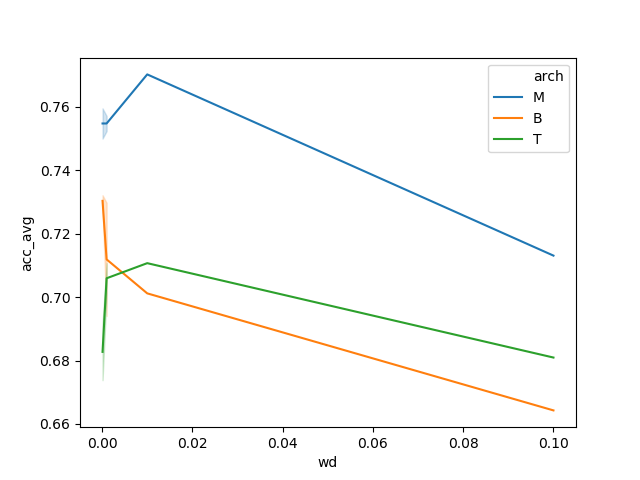

In [115]:
plt.figure()
sns.lineplot(data=df_val, x='wd',y='acc_avg',hue='arch')

In [ ]:
for conv in [GATConv]:
    for ch in [12,24,48,96]:
        for lr in [1e-3,5e-3,1e-2]:
            for dropout in [0.2,0.4,0.6,0.8]:
                for wd in [1e-4,1e-3,1e-2,1e-1]:
                    for heads in [1,2,4]:   # flaw when ch==12 and heads==4 and model is BiGAT (12//2//4 => 1)
                                            # resulting in smaller representation size than expected (ch -> 8 not 12)
                        eval_archs_gat(dataset=cora,conv=conv,channel_size=ch,lr=lr,
                                       dropout=dropout,wd=wd,heads=heads)

In [ ]:
eval_archs(cora,SAGEConv,64,0.1,0.01)

In [ ]:
eval_archs_gat(cora,GATConv,64,0.01,0.01)

>> acc/GATConv_MonoGAT_lr0.01_wd0.01_ch64.out


In [19]:
eval_archs(cora,SAGEConv,64,0.1,0.01)

RuntimeError: Expected object of device type cuda but got device type cpu for argument #2 'mat2' in call to _th_mm

In [ ]:
eval_archs(cora,SAGEConv,64,0.001,0.1)

In [ ]:
eval_archs(cora,GCNConv,64,0.01,5e-4)

In [ ]:
avg = 0
with open('acc/monogcn.out','w') as f:
    for seed in range(num_splits):
        monogcn,monogcnstd,monogcns = eval_multiple(cora,[64],GCNConv,runs=num_runs,epochs=200,split_seed=seed,
                                                    architecture=MonoModel)
        f.write('Mono accuracy: {:.2f} +-{:.1f}\n'.format(monogcn*100,monogcnstd*100))
        avg += monogcn / num_splits
    f.write('Mono accuracy: {:.2f}\n'.format(avg*100))

In [ ]:
avg = 0
with open('acc/bigcn.out','w') as f:
    for seed in range(num_splits):
        monogcn,monogcnstd,monogcns = eval_multiple(cora,[32],GCNConv,runs=num_runs,epochs=200,split_seed=seed,
                                                    architecture=BiModel)
        f.write('Mono accuracy: {:.2f} +-{:.1f}\n'.format(monogcn*100,monogcnstd*100))
        avg += monogcn / num_splits
    f.write('Mono accuracy: {:.2f}\n'.format(avg*100))

In [ ]:
avg = 0
with open('acc/trigcn.out','w') as f:
    for seed in range(num_splits):
        monogcn,monogcnstd,monogcns = eval_multiple(cora,[20],GCNConv,runs=num_runs,epochs=200,split_seed=seed,
                                                    architecture=TriModel)
        f.write('Mono accuracy: {:.2f} +-{:.1f}\n'.format(monogcn*100,monogcnstd*100))
        avg += monogcn / num_splits
    f.write('Mono accuracy: {:.2f}\n'.format(avg*100))

In [12]:
avg = 0
for seed in range(10):
    monogcn,monogcnstd,monogcns = eval_multiple(cora,[128],SAGEConv,runs=10,epochs=200,split_seed=seed,
                                                architecture=MonoModel)
    
    avg += monogcn / 10
print('Mono accuracy: {:.4f}'.format(avg))

Elaplsed 00:00:03
Elaplsed 00:00:03
Elaplsed 00:00:03
Elaplsed 00:00:03
Elaplsed 00:00:03
Elaplsed 00:00:03
Elaplsed 00:00:03
Elaplsed 00:00:03
Elaplsed 00:00:03
Elaplsed 00:00:03
Mono accuracy: 0.7433


In [13]:
avg = 0
for seed in range(10):
    monogcn,monogcnstd,monogcns = eval_multiple(cora,[64],SAGEConv,runs=10,epochs=200,split_seed=seed,
                                                architecture=BiModel)
    avg += monogcn / 10
print('Mono accuracy: {:.4f}'.format(avg))

Elaplsed 00:00:04
Elaplsed 00:00:03
Elaplsed 00:00:04
Elaplsed 00:00:04
Elaplsed 00:00:04
Elaplsed 00:00:05
Elaplsed 00:00:05
Elaplsed 00:00:05
Elaplsed 00:00:05
Elaplsed 00:00:05
Mono accuracy: 0.7463


In [14]:
avg = 0
for seed in range(10):
    monogcn,monogcnstd,monogcns = eval_multiple(cora,[45],SAGEConv,runs=10,epochs=200,split_seed=seed,
                                                architecture=TriModel)
    avg += monogcn / 10
print('Mono accuracy: {:.4f}'.format(avg))

Elaplsed 00:00:05
Elaplsed 00:00:05
Elaplsed 00:00:05
Elaplsed 00:00:05
Elaplsed 00:00:05
Elaplsed 00:00:05
Elaplsed 00:00:04
Elaplsed 00:00:04
Elaplsed 00:00:04
Elaplsed 00:00:04
Mono accuracy: 0.7429


In [54]:
model= MonoModel(GCNConv,cora,[8])

In [89]:
split0 = NetworkSplit(cora[0])

In [96]:
(split0.train_mask | (split0.val_mask)).sum().item()

601

### GCN

In [25]:
monogcn,monogcnstd,monogcns = eval_multiple(coraConfDirected,[128],GCNConv,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))

Elaplsed 00:03:52
Mono accuracy: 0.2926+-0.0196


In [26]:
monogcn,monogcnstd,monogcns = eval_multiple(coraConfReversed,[128],GCNConv,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))

Elaplsed 00:02:08
Mono accuracy: 0.3161+-0.0118


In [29]:
monogcn,monogcnstd,monogcns = eval_multiple(citeseerConfDirected,[128],GCNConv,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))

Elaplsed 00:02:28
Mono accuracy: 0.3269+-0.0262


In [31]:
monogcn,monogcnstd,monogcns = eval_multiple(citeseerConfReversed,[128],GCNConv,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))

Elaplsed 00:02:30
Mono accuracy: 0.3490+-0.0145


In [30]:
monogcn,monogcnstd,monogcns = eval_multiple(PubMedConfDirected,[128],GCNConv,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))

Elaplsed 00:02:52
Mono accuracy: 0.5589+-0.0201


In [32]:
monogcn,monogcnstd,monogcns = eval_multiple(PubMedConfReversed,[128],GCNConv,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))

Elaplsed 00:03:02
Mono accuracy: 0.5972+-0.0054


In [16]:
monogcn,monogcnstd,monogcns = eval_multiple(coraDirected,[128],GCNConv,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))
monogcn,monogcnstd,monogcns = eval_multiple(citeseerDirected,[128],GCNConv,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))

Elaplsed 00:04:44
Mono accuracy: 0.7026+-0.0108
Elaplsed 00:03:35
Mono accuracy: 0.6541+-0.0190


In [13]:
monogcn,monogcnstd,monogcns = eval_multiple(PubMedDirected,[128],GCNConv,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))

Elaplsed 00:03:26
Mono accuracy: 0.6575+-0.0075


In [17]:
monogcn,monogcnstd,monogcns = eval_multiple(coraReversed,[128],GCNConv,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))
monogcn,monogcnstd,monogcns = eval_multiple(citeseerReversed,[128],GCNConv,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))

Elaplsed 00:03:17
Mono accuracy: 0.6368+-0.0120
Elaplsed 00:03:59
Mono accuracy: 0.6290+-0.0104


In [12]:
monogcn,monogcnstd,monogcns = eval_multiple(PubMedReversed,[128],GCNConv,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))

Elaplsed 00:02:57
Mono accuracy: 0.6680+-0.0045


In [23]:
eval_all(GCNConv,cora,[128],[64],[42])
eval_all(GCNConv,citeseer,[128],[64],[42])
eval_all(GCNConv,PubMed,[128],[64],[42],runs=100)

Elaplsed 00:02:38
Mono accuracy: 0.8093
Elaplsed 00:02:05
Bi   accuracy: 0.8049
Elaplsed 00:02:05
Tri  accuracy: 0.8021
Elaplsed 00:02:31
Mono accuracy: 0.7212
Elaplsed 00:02:15
Bi   accuracy: 0.7189
Elaplsed 00:02:27
Tri  accuracy: 0.7179
Elaplsed 00:03:57
Mono accuracy: 0.7734
Elaplsed 00:02:50
Bi   accuracy: 0.7721
Elaplsed 00:02:32
Tri  accuracy: 0.7716


In [17]:
eval_all(GCNConv,cora,[128],[64],[42])

Elaplsed 00:03:11
Mono accuracy: 0.8096
Elaplsed 00:02:59
Bi   accuracy: 0.8036
Elaplsed 00:02:57
Tri  accuracy: 0.8019


In [20]:
eval_all(GCNConv,citeseer,[128],[64],[42])

Elaplsed 00:03:45
Mono accuracy: 0.7218
Elaplsed 00:03:27
Bi   accuracy: 0.7192
Elaplsed 00:03:24
Tri  accuracy: 0.7171


In [8]:
eval_all(GCNConv,PubMed,[128],[64],[42],runs=100)

Elaplsed 00:05:03
Mono accuracy: 0.7729
Elaplsed 00:07:13
Bi   accuracy: 0.7725
Elaplsed 00:03:11
Tri  accuracy: 0.7720


### SAGE

In [33]:
monogcn,monogcnstd,monogcns = eval_multiple(coraDirected,[128],SAGEConv,lr=0.1,wd=1e-5,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))
monogcn,monogcnstd,monogcns = eval_multiple(citeseerDirected,[128],SAGEConv,lr=0.1,wd=1e-5,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))

Elaplsed 00:01:40
Mono accuracy: 0.7320+-0.0113
Elaplsed 00:02:03
Mono accuracy: 0.6821+-0.0112


In [15]:
monogcn,monogcnstd,monogcns = eval_multiple(PubMedDirected,[128],SAGEConv,lr=0.1,wd=1e-5,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))

Elaplsed 00:03:59
Mono accuracy: 0.6816+-0.0090


In [34]:
monogcn,monogcnstd,monogcns = eval_multiple(coraReversed,[128],SAGEConv,lr=0.1,wd=1e-5,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))
monogcn,monogcnstd,monogcns = eval_multiple(citeseerReversed,[128],SAGEConv,lr=0.1,wd=1e-5,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))


Elaplsed 00:01:40
Mono accuracy: 0.6675+-0.0126
Elaplsed 00:02:04
Mono accuracy: 0.6229+-0.0239


In [14]:
monogcn,monogcnstd,monogcns = eval_multiple(PubMedReversed,[128],SAGEConv,lr=0.1,wd=1e-5,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))

Elaplsed 00:03:56
Mono accuracy: 0.6921+-0.0092


In [35]:
monogcn,monogcnstd,monogcns = eval_multiple(coraConfDirected,[128],SAGEConv,lr=0.1,wd=1e-5,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))
monogcn,monogcnstd,monogcns = eval_multiple(citeseerConfDirected,[128],SAGEConv,lr=0.1,wd=1e-5,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))
monogcn,monogcnstd,monogcns = eval_multiple(PubMedConfDirected,[128],SAGEConv,lr=0.1,wd=1e-5,runs=100,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))

Elaplsed 00:01:47
Mono accuracy: 0.2034+-0.0435
Elaplsed 00:02:07
Mono accuracy: 0.2685+-0.0209
Elaplsed 00:03:10
Mono accuracy: 0.4124+-0.0173


In [37]:
monogcn,monogcnstd,monogcns = eval_multiple(coraConfReversed,[128],SAGEConv,lr=0.1,wd=1e-5,runs=50,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))
monogcn,monogcnstd,monogcns = eval_multiple(citeseerConfReversed,[128],SAGEConv,lr=0.1,wd=1e-5,runs=50,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))
monogcn,monogcnstd,monogcns = eval_multiple(PubMedConfReversed,[128],SAGEConv,lr=0.1,wd=1e-5,runs=50,epochs=200)
print('Mono accuracy: {:.4f}+-{:.4f}'.format(monogcn,monogcnstd))

Elaplsed 00:00:53
Mono accuracy: 0.2674+-0.0215
Elaplsed 00:01:03
Mono accuracy: 0.2658+-0.0173
Elaplsed 00:01:34
Mono accuracy: 0.5926+-0.0099


In [41]:
eval_all_SAGE(coraConf,[128],[64],[42],runs=50)
eval_all_SAGE(citeseerConf,[128],[64],[42],runs=50)
eval_all_SAGE(PubMedConf,[128],[64],[42],runs=50)

Elaplsed 00:00:53
Mono accuracy: 0.2650+-0.0194
Elaplsed 00:00:54
Bi   accuracy: 0.3101+-0.0153
Elaplsed 00:00:54
Tri  accuracy: 0.3042+-0.0176
Elaplsed 00:01:04
Mono accuracy: 0.3002+-0.0312
Elaplsed 00:00:56
Bi   accuracy: 0.3455+-0.0201
Elaplsed 00:00:54
Tri  accuracy: 0.3403+-0.0144
Elaplsed 00:01:44
Mono accuracy: 0.4851+-0.0149
Elaplsed 00:01:15
Bi   accuracy: 0.4836+-0.0155
Elaplsed 00:01:06
Tri  accuracy: 0.4838+-0.0158


In [19]:
eval_all_SAGE(cora,[128],[64],[42])

Elaplsed 00:02:19
Mono accuracy: 0.8045
Elaplsed 00:02:27
Bi   accuracy: 0.8005
Elaplsed 00:03:13
Tri  accuracy: 0.7979


In [20]:
eval_all_SAGE(citeseer,[128],[64],[42])

Elaplsed 00:04:00
Mono accuracy: 0.7214
Elaplsed 00:04:43
Bi   accuracy: 0.7300
Elaplsed 00:04:33
Tri  accuracy: 0.7273


In [21]:
eval_all_SAGE(PubMed,[128],[64],[42],runs=100)

Elaplsed 00:08:02
Mono accuracy: 0.7707
Elaplsed 00:06:13
Bi   accuracy: 0.7764
Elaplsed 00:04:54
Tri  accuracy: 0.7783


OLD

In [22]:
eval_all(SAGEConv,cora,[128],[64],[42])

Elaplsed 00:02:21
Mono accuracy: 0.8029
Elaplsed 00:02:18
Bi   accuracy: 0.7998
Elaplsed 00:02:19
Tri  accuracy: 0.8003


In [23]:
eval_all(SAGEConv,citeseer,[128],[64],[42])

Elaplsed 00:02:42
Mono accuracy: 0.7196
Elaplsed 00:01:48
Bi   accuracy: 0.7164
Elaplsed 00:01:43
Tri  accuracy: 0.7122


In [9]:
eval_all(SAGEConv,PubMed,[128],[64],[42],runs=100)

Elaplsed 00:04:16
Mono accuracy: 0.7728
Elaplsed 00:06:08
Bi   accuracy: 0.7702
Elaplsed 00:06:08
Tri  accuracy: 0.7703


---------------------------------------- The rest is test --------------------------------------------

In [15]:
eval_all(GCNConv,cora,[16],[8],[5])

Elaplsed 00:03:13
Mono accuracy: 0.7970
Elaplsed 00:03:03
Bi   accuracy: 0.7813
Elaplsed 00:03:03
Tri  accuracy: 0.7425


In [16]:
eval_all(GCNConv,cora,[64],[32],[20])

Elaplsed 00:03:05
Mono accuracy: 0.8043
Elaplsed 00:03:03
Bi   accuracy: 0.8017
Elaplsed 00:03:04
Tri  accuracy: 0.7995


In [18]:
eval_all(GCNConv,citeseer,[16],[8],[5])

Elaplsed 00:03:01
Mono accuracy: 0.7175
Elaplsed 00:03:01
Bi   accuracy: 0.7054
Elaplsed 00:03:05
Tri  accuracy: 0.6618


In [19]:
eval_all(GCNConv,citeseer,[64],[32],[20])

Elaplsed 00:03:38
Mono accuracy: 0.7197
Elaplsed 00:03:15
Bi   accuracy: 0.7170
Elaplsed 00:03:12
Tri  accuracy: 0.7186
